In [1]:
import os
import pandas as pd
import yaml

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_32896\2285392039.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
root_dir = r".\results\2024Apr06-015143_configs"

In [3]:
def collect_experiment_data(root_dir):
    """
    Collects experiment data and selected parameters from configuration files across multiple runs.

    Parameters:
    - root_dir: The root directory where experiment results are stored.

    Returns:
    - A pandas DataFrame containing the collected data and parameters.
    """
    all_data = []

    # Walk through the directory structure
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith("loss_record.csv"):
                # Path to the current file
                file_path = os.path.join(subdir, file)
                # Read the loss record CSV file
                df = pd.read_csv(file_path)

                # Load the corresponding cfg.yaml file to get parameters
                cfg_path = os.path.join(subdir, "cfg.yaml")
                with open(cfg_path, "r") as cfg_file:
                    cfg_data = yaml.safe_load(cfg_file)

                # Extract needed parameters
                run_id = cfg_data.get("run_id")
                tau = cfg_data["tau"]
                min_samples = cfg_data["min_samples"]

                # Add parameters as new columns to the DataFrame
                df["run_id"] = run_id
                df["tau"] = tau
                df["min_samples"] = min_samples

                # Append to the list of all data
                all_data.append(df)

    # Concatenate all data into a single DataFrame
    return pd.concat(all_data, ignore_index=True)


combined_data = collect_experiment_data(root_dir)
combined_data

aggregated_df = (
    combined_data.groupby(["run_id", "tau", "min_samples"])
    .agg({"epoch": "max"})
    .reset_index()
)

aggregated_df

,run_id,tau,min_samples,epoch
0,0,0.001,20,299
1,0,0.010,20,299
2,0,0.100,20,299
3,0,1.000,20,299
4,0,10.000,20,299
5,1,0.001,20,299
6,1,0.010,20,299
7,1,0.100,20,299
8,1,1.000,20,299
9,1,10.000,20,299


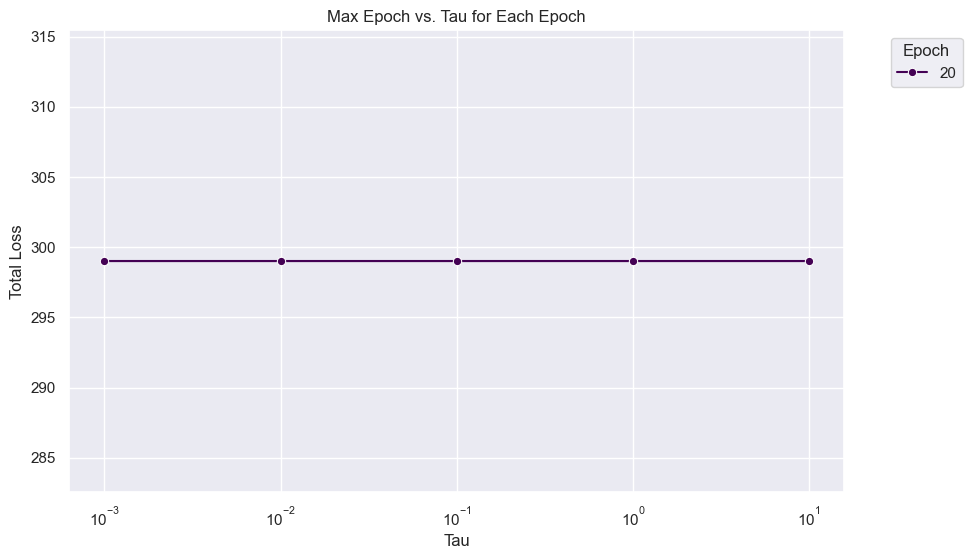

In [4]:
plt.figure(figsize=(10, 6))
# Assuming you want to plot the loss for the last epoch of each run, you can filter or aggregate the data as needed
sns.lineplot(
    data=aggregated_df,
    x="tau",
    y="epoch",
    hue="min_samples",
    palette="viridis",
    marker="o",
)
plt.xlabel("Tau")
plt.ylabel("Total Loss")
plt.xscale("log")
# plt.yscale('log')
plt.title("Max Epoch vs. Tau for Each Epoch")
plt.legend(title="Epoch", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [5]:
def collect_bellman_errors(root_dir):
    """
    Collects Bellman error values and selected parameters from configuration files across multiple runs.

    Parameters:
    - root_dir: The root directory where experiment results are stored.

    Returns:
    - A pandas DataFrame containing the collected Bellman errors and parameters.
    """
    all_errors = []

    # Walk through the directory structure
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file == "bellman_error.txt":
                # Path to the current file
                file_path = os.path.join(subdir, file)
                # Read the Bellman error value from the file
                with open(file_path, "r") as error_file:
                    bellman_error = float(error_file.read().strip())

                # Load the corresponding cfg.yaml file to get parameters
                cfg_path = os.path.join(subdir, "cfg.yaml")
                with open(cfg_path, "r") as cfg_file:
                    cfg_data = yaml.safe_load(cfg_file)

                # Extract needed parameters
                run_id = cfg_data.get("run_id")
                tau = cfg_data["tau"]
                min_samples = cfg_data["min_samples"]

                # Create a dictionary with the collected data
                error_data = {
                    "run_id": run_id,
                    "tau": tau,
                    "min_samples": min_samples,
                    "bellman_error": bellman_error,
                }

                # Append to the list of all errors
                all_errors.append(error_data)

    # Convert the list of dictionaries to a DataFrame
    return pd.DataFrame(all_errors)


# Example usage
bellman_errors_df = collect_bellman_errors(root_dir)
bellman_errors_df

,run_id,tau,min_samples,bellman_error
0,0,0.001,20,2.038751e-02
1,1,0.001,20,1.373435e-02
2,2,0.001,20,5.470418e+10
3,3,0.001,20,2.688152e+07
4,4,0.001,20,1.685980e-02
5,0,0.010,20,3.906596e+07
6,1,0.010,20,6.224159e+08
7,2,0.010,20,1.609318e+09
8,3,0.010,20,1.218374e+02
9,4,0.010,20,2.141823e-02


In [6]:
# bellman_errors_df_filtered = bellman_errors_df[bellman_errors_df["tau"]!=0.01]
bellman_errors_df_filtered = bellman_errors_df[bellman_errors_df["min_samples"] != 0]

In [8]:
bellman_errors_df_filtered["min_samples"] = bellman_errors_df_filtered[
    "min_samples"
].astype(str)

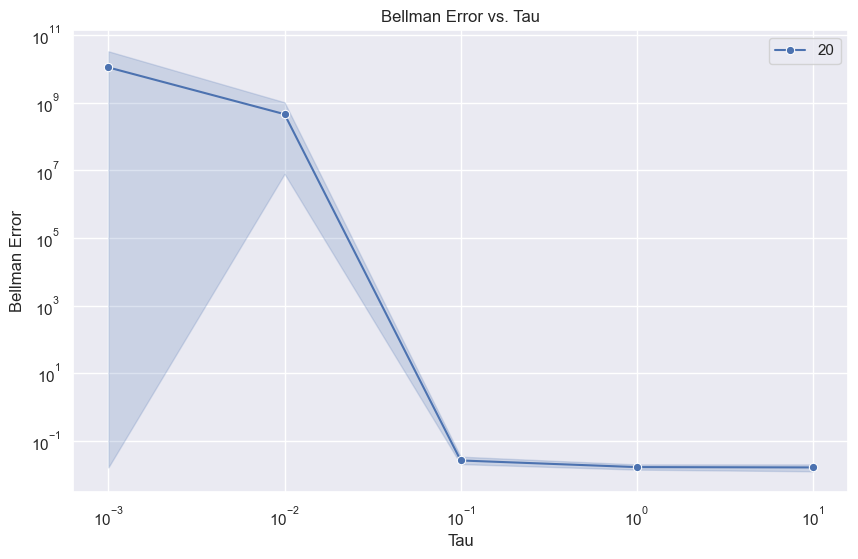

In [9]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=bellman_errors_df_filtered,
    x="tau",
    y="bellman_error",
    hue="min_samples",
    marker="o",
    # label="Bellman Error",
)
plt.xlabel("Tau")
plt.ylabel("Bellman Error")
plt.xscale("log")
plt.yscale("log")
plt.title("Bellman Error vs. Tau")
plt.legend()
plt.show()

In [10]:
high_tau_df = bellman_errors_df_filtered[bellman_errors_df_filtered["tau"] == 1]
high_tau_df["bellman_error"].mean()

0.01667773086577654

In [11]:
bellman_errors_df_filtered["bellman_error"].min()

0.01045125611126423

In [15]:
bellman_errors_df_filtered

,run_id,tau,min_samples,bellman_error
0,0,0.001,20,2.038751e-02
1,1,0.001,20,1.373435e-02
2,2,0.001,20,5.470418e+10
3,3,0.001,20,2.688152e+07
4,4,0.001,20,1.685980e-02
5,0,0.010,20,3.906596e+07
6,1,0.010,20,6.224159e+08
7,2,0.010,20,1.609318e+09
8,3,0.010,20,1.218374e+02
9,4,0.010,20,2.141823e-02


In [12]:
# use mdp to generate transition distribution
# this generates another dataset of transitions

# then apply:
# ### Training
# input_size = len(states[0])  # Or another way to represent the size of your input
# output_size = len(actions)

# # Initialize the DQN
# dqn = DQN(input_size, output_size)

# loss_record = train_dqn(
#     dqn,
#     sampled_transitions_train,
#     Q_pi_random,
#     states,
#     actions,
#     gamma,
#     epsilon,
#     batch_size=batch_size,
#     max_iterations=train_max_iterations,
#     logger=logger,
# )

# bm_error = compute_bellmans_error(
#     dqn, validation_transitions=transitions_val, gamma=gamma
# )

### AND

# policy evaluation

# plot both

In [13]:
# do policy evaluation on train datasets -> Q
# Evaluate with Q on validation set

# training DQN == value iteration
# we want to do policy evaluation with DQN (we do this by changing the loss function with bellman equation for Q pi instead of Q*)
# if we want to do early stopping, do it with Q* instead of Q pi random

In [14]:
print(30 * 20 * 3, 30.75 / (30 * 20 * 3))
print(35 * 25 * 4, 34.7 / (35 * 25 * 4))
print(35 * 27 * 5, 32.2 / (35 * 27 * 5))
print(41 * 25 * 8, 40.49 / (41 * 25 * 8))
print(43 * 29 * 7.5, 60 / (43 * 29 * 7.5))
print(44 * 34 * 5, 46 / (44 * 34 * 5))

1800 0.017083333333333332
3500 0.009914285714285716
4725 0.006814814814814815
8200 0.004937804878048781
9352.5 0.006415396952686447
7480 0.006149732620320855
